# 関数定義

In [ ]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [1]:
# sstの陸面をマスクする関数
def mask(x):
    m = ma.masked_where(x>9999, x)
    z = ma.masked_where(m==0, m)
    f = ma.filled(z, np.nan) # for masking
    #f = ma.filled(z, 0) # for filing with 0
    return f

In [2]:
# (緯度、経度、時間)の三次元情報を => (空間, 時間)の二次元行列に変換する関数
def latlon_to_X(var):
    # 三次元情報それぞれのshapeを取得
    imt, jmt, tmt = var.shape
    # 出力行列Xのshapeを決定
    X = np.zeros((imt*jmt, tmt))
    
    # 行列に変換
    cc = 0 # 行列Xの空間次元のインデックス
    for ii in range(0, imt):
        for jj in range(0, jmt):
            # マスクされている場合は行列に含めない
            if np.isnan(var[ii, jj, 0]) == False:
                X[cc, :] = np.squeeze(var[ii, jj, :])
                cc = cc + 1
    X = np.squeeze(X[0:cc, :]) #squeezeは長さが1の軸が存在する場合に取り除くための保険
    return X

In [3]:
# 二次元行列を三次元に変換する関数
def X_to_latlon(X):
    #　対象とする地域の降水データグリッドサイズが20x20の行列なので、手動でimt,jmtを設定
    imt, jmt = 20, 20
    
    SVDs = np.zeros((imt, jmt))
    
    # 行列を三次元情報に復元
    cc = 0
    for ii in range(0, imt):
        for jj in range(0, jmt):
            SVDs[ii, jj] = X[cc]
            cc += 1
    
    return SVDs

In [4]:
# sstを可視化するための関数
def show_sst(image, img_extent):
    projection = ccrs.PlateCarree(central_longitude=180)

    fig = plt.figure()
    ax = plt.subplot(projection=projection)
    ax.coastlines()
    mat = ax.matshow(image,
                     origin='upper',
                     extent=img_extent,
                     transform=projection)
    cbar = fig.colorbar(mat, 
                        extend='both',
                        spacing='proportional',
                        orientation='horizontal')
    plt.show()

In [10]:
# prcpを可視化するための関数
def show_prcp(image):
    projection =ccrs.PlateCarree(central_longitude=180)
    img_extent = (-90, -70, 5, 25) # location=(N5-25, #90-110)
    
    fig = plt.figure()
    ax = plt.subplot(projection=projection)
    ax.coastlines()
    mat = ax.matshow(image,
                     origin='upper',
                     extent=img_extent,
                     transform=projection,
                     vmin=-1.5, vmax=1.5) # vminとvmaxは結果を見て見やすいように調整
    cbar = fig.colorbar(mat, 
                        extend='both',
                        spacing='proportional',
                        orientation='vertical')
    plt.show()

# データの読み込み

In [11]:
# データ保存場所のパスを記述
workdir = '/docker/mnt/d/research/D2/cnn3'
sst_path = workdir + '/predictors/predictors_coarse_std_Apr_o.npy'
prcp_path = workdir + '/predictant/continuous/pr_1x1_std_MJJASO_thailand.npy'

# sstとprcpのshapeを確認
# sstは5x5°解像度を使用
sst = np.squeeze(np.load(sst_path)) # [モデルの種類42, 年(1851-2014)165, 緯度(S60-N60)24, 経度(E0-360)72]
# prcpは1x1°の解像度を使用
prcp = np.load(prcp_path) # [モデルの種類42, 年(1851-2014)165, 緯度(N10-20)20, 経度(E95-110)20]
print(sst.shape, prcp.shape)

(42, 165, 24, 72) (42, 165, 20, 20)


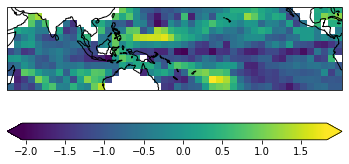

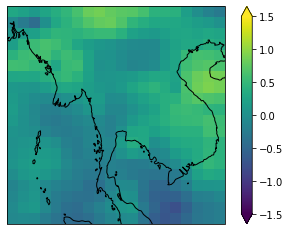

In [12]:
#SSTの中央太平洋とインド洋を抜き出して可視化: E45-W75, S30-N30
img_extent = (-135, 105, -30, 30)
sst_m0_y0 = sst[0, 0, :, :]
prcp_masked = mask(sst_m0_y0)
ocean = prcp_masked[6:18, 9:57]
show_sst(ocean, img_extent)

#PRCPについても可視化: N10-20, E95-110
prcp_m0_y0 = prcp[0, 0, :, :]
show_prcp(prcp_m0_y0)

# 特異値行列の計算

In [14]:
# 今回はモデル番号1(BCC-CSM2-MR)の1984-2014年のデータをもとに特異値行列を計算
training_model_index = 1 # 用いるモデルの番号
training_period = -30 # 用いる年の範囲

# sstとprcp行列を作成
umi = sst[training_model_index, training_period:, 6:18, 9:57] # 太平洋とインド洋の部分を切り出し
umi = umi.transpose(1,2,0) # 時間次元の位置を一番後ろに移動
umi = mask(umi) # 陸域をマスク
X = latlon_to_X(umi) # SSTの行列を作成

ame = prcp[training_model_index, training_period:, :, :]# 降水のデータを切り出し
ame = ame.transpose(1,2,0) # 時間次元の位置を一番後ろに移動
Y = latlon_to_X(ame) # PRCPの行列を作成

print(X.shape, Y.shape)

(470, 30) (400, 30)


In [15]:
# 共分散行列を作成
N = X.shape[1] # 時間方向のshape(30年)
C_XY = X@Y.T/N 

# 特異値分解で左右特異行列P, Qを取得
P, S, QT = np.linalg.svd(C_XY, full_matrices=False)
# 右特異行列を転置
Q = QT.T

print(C_XY.shape)
print(P.shape, Q.shape)

(470, 400)
(470, 400) (400, 400)


# 再現実験

In [17]:
# 特異値分解に用いたモデル番号1(BCC-CSM2-MR)の2014年のデータを再現できるかを確認
validation_model_index = 1 # 用いるモデルの番号
validation_year_index = -1 # 用いる年(2014年)

tmp = sst[validation_model_index, :, 6:18, 9:57] # インド洋と太平洋を切り抜き
tmp = tmp.transpose(1,2,0) # 時間次元の位置を一番後ろに移動
tmp = mask(tmp) # 陸域をマスク
X = latlon_to_X(tmp) # sstの行列を作成

# 時間展開係数 Aを計算
sst_input = X[:, validation_year_index] # 2014年のsstをインプットとして用意

A = P.T@sst_input # 時間発展係数　=　左特異行列　＊　SST行列

In [26]:
# PRCP行列を緯度経度座標に復元
grids = 20*20 # 雨データのグリッド数(緯度グリッド20 * 経度グリッド20)
prcp_output = np.zeros(grids)
# モード毎にprcpを計算して足し合わせる
for i in range(A.shape[0]):
    mode_i = Q.T[i]*A[i] # PRCPのi番目のモード = 右特異行列 * 時間発展係数B(Bが未知なのでAで代用)
    prcp_output += mode_i # 各モードを足し合わせる
print(prcp_output.shape)

(400,)


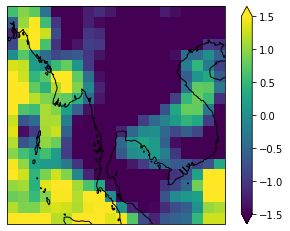

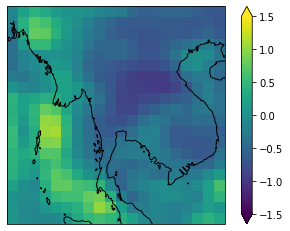

In [27]:
# 可視化
# 特異値解析で得られた降水量分布
prcp_latlon = X_to_latlon(prcp_output)
show_prcp(prcp_latlon)

# 元データから得られた降水量
prcp_label = prcp[validation_model_index, validation_year_index, :, :]
show_prcp(prcp_label)

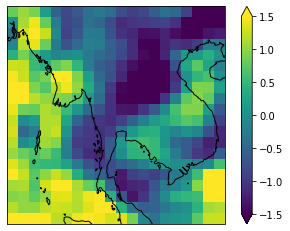

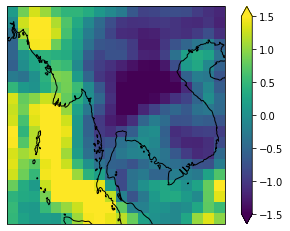

In [28]:
# 可視化2 (上と同じデータを別方法で可視化)
# 上だと合ってないように見えるけれど、それぞれの分散で正規化すると分布はあっている
latlon_norm = (prcp_latlon-np.mean(prcp_latlon))/np.std(prcp_latlon)
show_prcp(latlon_norm)

label_norm = (prcp_label-np.mean(prcp_label))/np.std(prcp_label)
show_prcp(label_norm)

# 特異値解析に用いていないデータの降水量予測

In [39]:
# 予測に用いるモデルはモデル番号2(BCC-ESM1) 年は2014年
validation_model_index = 2
validation_year_index = -1

# prediction
tmp = sst[validation_model_index, :, 6:18, 9:57] # indian ocean and pacific ocean
tmp = tmp.transpose(1,2,0) # transpose time at last position
tmp = mask(tmp) # mask land area in sst data
X = latlon_to_X(tmp) # convert data (points, time)

# calculate time expansion coefficient A
sst_input = X[:, validation_year_index] # year:-1=2014

A = P.T@sst_input

# reconstruct prcp
grids = 20*20
prcp_output = np.zeros(grids)
for i in range(grids):
    mode_i = Q.T[i]*A[i]
    prcp_output += mode_i

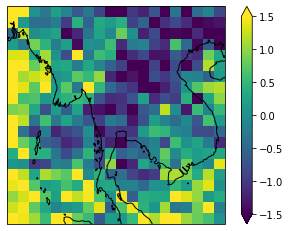

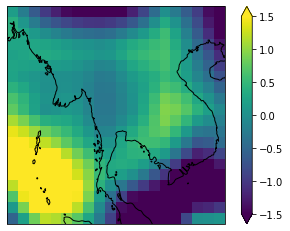

In [42]:
# 分散で正規化して可視化
# 特異値解析で得られた降水量分布
prcp_latlon = X_to_latlon(prcp_output)
latlon_norm = (prcp_latlon-np.mean(prcp_latlon))/np.std(prcp_latlon)
show_prcp(latlon_norm)

# 元データから得られた降水量
prcp_label = prcp[validation_model_index, validation_year_index, :, :]
label_norm = (prcp_label-np.mean(prcp_label))/np.std(prcp_label)
show_prcp(label_norm)

# 外挿問題において全く見当違いな結果になってしまう。->実装の問題なのでしょうか？